# Lab 09: MLB Swing Probability Modeling

---
author: Brady Brooks
date: November 15, 2024
embed-resources: true
---

## Introduction

In this report, I build a probability model that estimates the probability of a batter to swing at a pitch. We want to determine the likelihood a batter will swing at a given pitch based on numerous factors about the pitch and the game situatiion. To do so, I trained a Logistic Regression model with the provided observations from pitcher, Zac Gallen.

## Methods

In [88]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, fbeta_score, make_scorer
import warnings

### Data

In [8]:
# load data
pitches_train = pd.read_csv("https://cs307.org/lab-09/data/pitches-train.csv")
pitches_test = pd.read_csv("https://cs307.org/lab-09/data/pitches-test.csv")
pitches_train

,pitch_name,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_axis,plate_x,plate_z,...,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,stand,sz_top,sz_bot,swing
0,Cutter,6.6,-2.76,53.86,5.81,92.6,2376.0,195.0,-0.09,2.79,...,3,1,0,0,0,1,L,3.15,1.52,1
1,Changeup,6.8,-2.87,53.74,5.66,86.3,1511.0,226.0,-1.47,1.84,...,2,1,0,0,0,1,L,3.13,1.56,0
2,Changeup,6.7,-2.83,53.82,5.68,87.9,1570.0,224.0,-1.52,2.38,...,1,1,0,0,0,1,L,3.12,1.51,0
3,Knuckle Curve,6.7,-2.70,53.78,5.78,82.4,2398.0,32.0,0.20,1.04,...,1,0,0,0,0,1,L,3.15,1.52,1
4,Cutter,6.7,-2.64,53.83,5.81,91.0,2427.0,189.0,0.89,1.65,...,0,0,0,0,0,1,L,3.12,1.51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648,4-Seam Fastball,6.8,-2.64,53.75,5.99,93.4,2411.0,206.0,0.59,2.91,...,0,0,0,0,0,1,L,3.50,1.81,0
2649,Slider,6.3,-2.91,54.19,5.86,87.3,2541.0,113.0,1.38,1.73,...,1,2,0,0,0,0,R,3.19,1.48,1
2650,Knuckle Curve,6.4,-2.91,54.13,5.87,84.7,2539.0,35.0,0.81,0.11,...,1,1,0,0,0,0,R,3.19,1.48,1
2651,4-Seam Fastball,6.4,-2.67,54.13,6.04,94.3,2531.0,201.0,1.05,1.79,...,0,1,0,0,0,0,R,3.03,1.48,0


The data is from StatCast and the observations are on pitcher, Zac Gallan. Each observation is made up of statistics about the pitch, batter information, and situation information.

## Data Dictionary

##### Response

swing
-   [int64] whether or not the batter swung (1) or took (0) 


##### Features

pitch_name
-   [object] the name of the pitch to be thrown

release_extension
-   [float64] the airline the tweet was sent to

release_pos_x
-   [float64] Horizontal Release Position of the ball measured in feet from the catcher's perspective

release_pos_y
-   [float64] Release Position of the pitch measured in feet from teh catcher's perspective

release_pos_z
-   [float64] Vertical Release Position of the ball measured in feet from the catcher's perspective

release_speed
-   [float64] Velocity of the pitch

release_spin_rate
-   [float64] Spin rate of the pitch

spin_axis
-   [float64] The spin axis in the 2D X-Y plane in degrees from 0 to 360

plate_x
-   [float64] Horizontal position of the ball when it crosses home plate from the catcher's perspective

plate_z
-   [float64] Vertical position of the ball when it crosses home plate from the catcher's perspective

pfx_x
-   [float64] Horizontal movement in feet from the catcher's perspective

pfx_z
-   [float64] Vertical movement in feet from the catcher's perspective

balls
-   [int64] Pre-pitch number of balls in count

strikes
-   [int64] Pre-pitch number of strikes in count

on_3b
-   [int64] Pre-pitch MLB Player Id of Runner on 3B

on_2b
-   [int64] Pre-pitch MLB Player Id of Runner on 2B

on_1b
-   [int64] Pre-pitch MLB Player Id of Runner on 1B

outs_when_up
-   [int64] Pre-Pitch number of outs

stand
-   [object] Side of  the plate batter is standing

sz_top
-   [float64] Top of the batter's strike zone set by the operator when the ball is halfway to the plate

sz_bot
-   [float64] Bottom of the batter's strike zone set by the operator when the ball is halfway to the plate

In [26]:
# summary statistics
dfs = pitches_train.groupby("pitch_name").agg("sum").reset_index()
dfc = pitches_train.groupby("pitch_name").agg("count").reset_index()
tdf = pd.merge(dfs, dfc, on="pitch_name")
display(tdf[["pitch_name", "swing_x", "swing_y"]])

,pitch_name,swing_x,swing_y
0,4-Seam Fastball,611,1296
1,Changeup,192,358
2,Cutter,108,238
3,Knuckle Curve,293,633
4,Slider,63,128


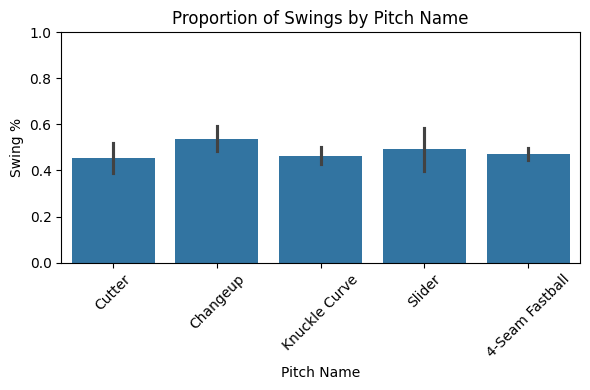

In [132]:
# visualizations
plt.figure(figsize=(6, 4))
sns.barplot(data=pitches_train, x='pitch_name', y='swing')
plt.title('Proportion of Swings by Pitch Name')
plt.ylabel('Swing %')
plt.xlabel('Pitch Name')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The visualization above tells us the swing percentage based on a pitch type. This tells us which types of pitches are swung at more often then others.

### Models

In [28]:
# process data for ML
# create X and y for train data
X_train = pitches_train.drop(columns=["swing"])
y_train = pitches_train["swing"]

# create X and y for test data
X_test = pitches_test.drop(columns=["swing"])
y_test = pitches_test["swing"]

To develop a model, I tuned two different types of Logistic Regression models. One set with solvers that utilize l2 and none penalty and another set of solvers that utilize l1 and l2 penalty. For each set, I tuned the models using several available tuning parameters. 

Furthermore, I preprocessed the features by imputing missing values for both categorical and numerical variables, as well as scaling the numeric variables. 

Tuning was performed via cross-validation using a grid-search of the specified parameters. The grid-search selects the model with the best los loss score. In addition, I used Calibrated Classifier cross-validation to strengthen the model's probability predictions.

In [37]:
# train models
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
# pipeline for numeric
numeric_preprocessor = Pipeline(steps=[
    ("MedianImputer", SimpleImputer(strategy="mean")), 
    ("Standardize", StandardScaler()),
    ])
# pipeline for categorical
categorical_preprocessor = Pipeline(steps=[
    ("ModelImputer", SimpleImputer(strategy="most_frequent")), 
    ("OneHotEncoder", OneHotEncoder(handle_unknown="ignore")),
    ])
# column transformer 
preprocessor = ColumnTransformer([
    ("NumericProcessing", numeric_preprocessor, numeric_features),
    ("CategoricalProcessing", categorical_preprocessor, categorical_features),
])
# full pipeline
pipeline = Pipeline(steps=[
    ("Preprocessor", preprocessor),
    ("Classifier", LogisticRegression())
])

In [102]:
param_grid = [
    {"Classifier": [LogisticRegression()],
    "Classifier__solver": ["lbfgs", "newton_cg", "newton_cholesky", "sag"],
    "Classifier__fit_intercept":  [False, True],
    "Classifier__C": np.arange(0.1, 1.5, 0.1),
    "Classifier__class_weight": [None, "balanced"],
    "Classifier__penalty": [None, "l2"]},
    {"Classifier": [LogisticRegression()],
    "Classifier__solver": ["liblinear", "saga"],
    "Classifier__fit_intercept":  [False, True],
    "Classifier__C": np.arange(0.1, 1.5, 0.1),
    "Classifier__class_weight": [None, "balanced"],
    "Classifier__penalty": ["l1", "l2"],}
]

In [ ]:
warnings.filterwarnings("ignore")
grid_search = GridSearchCV(pipeline, param_grid = param_grid, n_jobs=-1, cv=5, verbose=3, scoring="neg_log_loss")
_ = grid_search.fit(X_train, y_train)
mod = CalibratedClassifierCV(grid_search, method="isotonic", cv=3)
_ = mod.fit(X_train, y_train)

In [140]:
grid_search.best_params_

{'Classifier': LogisticRegression(),
 'Classifier__C': np.float64(0.1),
 'Classifier__class_weight': None,
 'Classifier__fit_intercept': True,
 'Classifier__penalty': 'l1',
 'Classifier__solver': 'liblinear'}

In [163]:
#Searching for the pitcher controlled variables that induce a batter's swing
temp = pitches_train[["release_extension", "release_pos_x", "release_pos_y", "release_pos_z", "release_speed", "release_spin_rate", "spin_axis", "plate_x", "plate_z", "swing"]]
corr = temp.corr()
corr2 = corr['swing'].drop('swing')
corr2 = corr2.sort_values(ascending=False)
corr2

plate_z              0.131900
spin_axis            0.027178
release_extension    0.006814
release_pos_z        0.002763
release_speed       -0.000101
release_pos_y       -0.004692
release_pos_x       -0.010005
release_spin_rate   -0.055245
plate_x             -0.073867
Name: swing, dtype: float64

## Results

In [67]:
from sklearn.calibration import calibration_curve
# function to calculate the calibration error
def calibration_error(y_true, y_prob, type="expected", n_bins=10):
    """
    Compute calibration error of a binary classifier.

    The calibration error measures the aggregated difference between
    the average predicted probabilities assigned to the positive class,
    and the frequencies of the positive class in the actual outcome.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True targets of a binary classification task.

    y_prob : array-like of (n_samples,)
        Estimated probabilities for the positive class.

    type : {'expected', 'max'}, default='expected'
        The expected-type is the Expected Calibration Error (ECE), and the
        max-type corresponds to Maximum Calibration Error (MCE).

    n_bins : int, default=10
       The number of bins used when computing the error.

    Returns
    -------
    score : float
        The calibration error.
    """

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.searchsorted(bins[1:-1], y_prob)

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    if type == "max":
        calibration_error = np.max(np.abs(prob_pred - prob_true))
    elif type == "expected":
        bin_error = np.abs(prob_pred - prob_true) * bin_total[nonzero]
        calibration_error = np.sum(bin_error) / len(y_true)
    return calibration_error
# function to plot a calibration_plot
def plot_calibration_plot(y_true, y_prob):
    # generate "data" for calibration plot
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, pos_label=1)
    # create a figure and axis object with a specific size
    fig, ax = plt.subplots()
    # plot the calibration curve
    ax.plot(prob_pred, prob_true, "s-", label="Learned Classifier", color="#1D58A7")
    # plot the diagonal "perfect" line
    ax.plot(
        [0, 1],
        [0, 1],
        "--",
        label="Perfect Calibration",
        color="#F5821E",
    )
    # set the plot title and axis labels
    ax.set_title("Calibration Plot")
    ax.set_xlabel("Mean Predicted Value")
    ax.set_ylabel("Fraction of Positives")
    # add a grid
    ax.grid(True, color="lightgrey", linewidth=0.75, linestyle="--",)
    # fix aspect ratio
    ax.set_aspect("equal",adjustable="box")
    ax.legend()
    plt.show()


Test ECE:  0.057873930294842696
TEST MCE:  0.09139740354344611


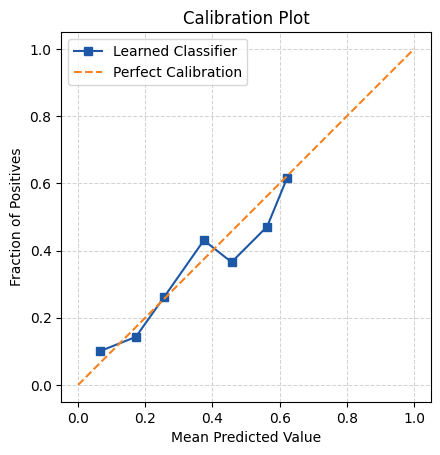

In [134]:
y_pred = mod.predict_proba(X_test)
print("Test ECE: ", calibration_error(y_test, y_pred[:,1]))
print("TEST MCE: ", calibration_error(y_test, y_pred[:,1], "max"))
plot_calibration_plot(y_test, y_pred[:,1])

The chosen model is a Logistic Regression using the liblinear solver, l1 penalty, a C of 0.1, an intercept, and no class weights.

The model achieves a test expected calibration error (ECE) is 0.057873930294842696.

The model achieves a test maximum calibration error (MCE) is 0.09139740354344611.

## Discussion

The model that I have created, which is the Logistic Regression using the liblinear solver and the l1 penalty, is successfully able to predict the probablility of a batter to swing at Gallen's pitch within a 0.06 expected error. The model could still be improved by trying different types of classification models and other tuning parameters. Other versions of calibrated cross-validation could be tested as well. If I tried to use this model as a MLB coach and wanted to induce a batter's swing, I would tell Gallen to throw a higher ball. The reason is because the pitcher is much more likely to swing at a higher ball as there is a correlation between Gallen's high pitches and batters swinging. The model can be interpreted in many ways and can help with making Gallen's decsion. On top of that, I can build an identical model for other pitchers using their pitches for the same purpose.

### Conclusion

Since the goal of this model does not impose high risk and the model is able to predict the probablity accurately, I would use this model in practice. The model will assist Gallen in deciding how to pitch on whether or not he wants to induce a swing or not.

In [122]:
from joblib import dump
dump(mod, "swing-probability.joblib")

['swing-probability.joblib']